Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time, json

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### Checking device

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device) # yes we are using colab's GPU

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Path

In [ ]:
data_dir = '/content/drive/MyDrive/deep_learning/Projet/data'
train_dir = data_dir + '/training'
valid_dir = data_dir + '/validation'

In [ ]:
print(train_dir, valid_dir)

/content/drive/MyDrive/deep_learning/Projet/data/training /content/drive/MyDrive/deep_learning/Projet/data/validation


### Data Description

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/deep_learning/Projet/monkey_labels.csv')

In [ ]:
df.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
df.columns

Index(['Label', 'Latin Name', ' Common Name', ' Train Images',
       'Validation Images'],
      dtype='object')

In [ ]:
print(f' Nous avons au total {df[" Train Images"].sum()} données de Train et  {df["Validation Images"].sum()} de Test. \n Soit au total {df[" Train Images"].sum() + df["Validation Images"].sum()} images') 

 Nous avons au total 1370 données de Train et  272 de Test. 
 Soit au total 1642 images


### Define transforms for the training and  validation sets

#### Les transformations sont effectuées dans l'ordre suivant :


#### transforms.RandomResizedCrop(224) : cette transformation redimensionne aléatoirement l'image pour une taille donnée et en effectue un recadrage aléatoire. Dans ce cas, la taille cible est de 224x224 pixels.


#### transforms.RandomHorizontalFlip() : cette transformation effectue un miroir horizontal aléatoire de l'image.


#### transforms.ToTensor() : cette transformation convertit les images de PIL (format de format d'image) en tenseurs PyTorch.


#### transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) : cette transformation effectue une normalisation des couleurs des images. Les premiers coefficients sont les moyennes des canaux RGB pour les données d'entraînement sur lesquelles le modèle a été entraîné, tandis que les secondes sont les écarts types.

#### Ces transformations sont agrégées en utilisant transforms.Compose, qui permet d'enchaîner plusieurs transformations en une seule opération.

In [ ]:
# Define transforms for the training and  validation sets
training_transforms = transforms.Compose([
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [ ]:
# Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)


# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)

### Construction et entraînement du classificateur

#### VGG16

In [ ]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Geler les paramètres du modèle pré-entraîné pour éviter la rétro-propagation à travers eux.
for parameter in model.parameters():
  parameter.requires_grad = False

#### 

In [ ]:
from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 20)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(20, 10)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=20, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (output): LogSoftmax(dim=1)
)

In [ ]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

### Entrainement du modèle

In [ ]:
def train_classifier():

        epochs = 20
        steps = 0
        print_every = 40

        model.to(device)

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to(device), labels.to(device)
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()    
                optimizer.step() # mettre à jour les poids et les biais du modèle
        
                running_loss += loss.item()
        
                if steps % print_every == 0:
                
                    model.eval() #  indique au modèle que nous sommes en mode évaluation
                
                    # désactivation du calcul de gradients pendant la validation
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
            
                    running_loss = 0
                    model.train()
                           

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
train_classifier() 

Epoch: 3/20..  Training Loss: 0.168..  Validation Loss: 0.745..  Validation Accuracy: 0.781
Epoch: 5/20..  Training Loss: 0.271..  Validation Loss: 0.327..  Validation Accuracy: 0.931
Epoch: 7/20..  Training Loss: 0.327..  Validation Loss: 0.236..  Validation Accuracy: 0.955
Epoch: 9/20..  Training Loss: 0.404..  Validation Loss: 0.179..  Validation Accuracy: 0.962
Epoch: 12/20..  Training Loss: 0.046..  Validation Loss: 0.198..  Validation Accuracy: 0.951
Epoch: 14/20..  Training Loss: 0.126..  Validation Loss: 0.180..  Validation Accuracy: 0.958
Epoch: 16/20..  Training Loss: 0.240..  Validation Loss: 0.159..  Validation Accuracy: 0.951
Epoch: 18/20..  Training Loss: 0.292..  Validation Loss: 0.162..  Validation Accuracy: 0.951
Epoch: 20/20..  Training Loss: 0.377..  Validation Loss: 0.166..  Validation Accuracy: 0.958


In [ ]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to(device)

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to(device), labels.to(device)
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
               

In [ ]:
test_accuracy(model, validate_loader)

Test Accuracy: 0.9583333134651184


In [ ]:
store_path = '/content/drive/MyDrive/deep_learning/'

In [ ]:
def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, store_path + 'checkpoint.pth')

In [ ]:
save_checkpoint(model)    

### Loading the checkpoint

In [ ]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 20)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(20, 10)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model


In [ ]:
checkPoint_model = load_checkpoint(store_path + 'checkpoint.pth')
checkPoint_model = checkPoint_model.to(device)
print(checkPoint_model.classifier)

Sequential(
  (fc1): Linear(in_features=25088, out_features=20, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (output): LogSoftmax(dim=1)
)


In [ ]:
print(checkPoint_model.class_to_idx)

{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


In [ ]:
#print(model.class_to_idx)

In [69]:
!cp /content/drive/MyDrive/deep_learning/Projet/tools.py /content/

In [ ]:
img_path = '/content/drive/MyDrive/deep_learning/Projet/data/validation' 

In [75]:
from tools import process_image

In [76]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    if title is not None:
        ax.set_title(title)

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

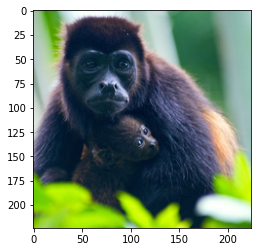

In [77]:
image = process_image(img_path + '/n0/n000.jpg')
imshow(image)

In [78]:
def predict(image_path, model, topk=10):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [79]:
probs, classes = predict(img_path + '/n0/n000.jpg', checkPoint_model)   
print(probs)
print(classes)

[0.9868848323822021, 0.012923547066748142, 0.00019158374925609678, 5.358726309911965e-11, 5.765510031202625e-12, 4.69058623051629e-14, 1.116326151120008e-14, 7.688731143953078e-17, 1.7361219075203892e-17, 1.0850745171595029e-17]
['n0', 'n9', 'n5', 'n1', 'n8', 'n7', 'n2', 'n4', 'n3', 'n6']


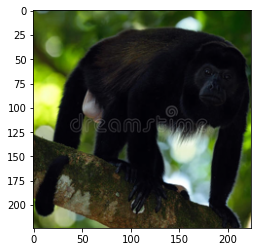

In [80]:
image = process_image(img_path + '/n0/n0017.jpg')
imshow(image)

In [81]:
probs, classes = predict(img_path + '/n0/n0017.jpg', checkPoint_model)   
print(probs)
print(classes)

[0.12045329809188843, 0.11975760012865067, 0.10194363445043564, 0.10047709196805954, 0.09879528731107712, 0.09676649421453476, 0.09588713198900223, 0.09030215442180634, 0.0892351046204567, 0.08638222515583038]
['n9', 'n1', 'n6', 'n3', 'n0', 'n7', 'n4', 'n2', 'n8', 'n5']


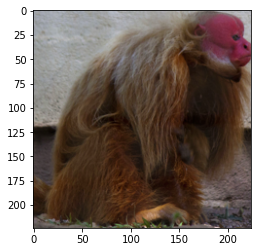

In [83]:
image = process_image(img_path + '/n2/n2014.jpg')
imshow(image)

In [84]:
probs, classes = predict(img_path + '/n2/n2014.jpg', checkPoint_model)   
print(probs)
print(classes)

[0.9983465671539307, 0.0016326201148331165, 2.0745263100252487e-05, 3.6424260940748354e-08, 3.56714124905011e-08, 5.646556555660709e-09, 1.1268701249900204e-11, 9.251753009531516e-12, 3.699404498014314e-12, 1.258480048416024e-14]
['n2', 'n1', 'n9', 'n0', 'n7', 'n3', 'n5', 'n6', 'n8', 'n4']


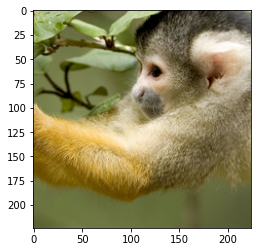

In [85]:
image = process_image(img_path + '/n7/n708.jpg')
imshow(image)

In [86]:
probs, classes = predict(img_path + '/n7/n708.jpg', checkPoint_model)   
print(probs)
print(classes)

[0.9816638827323914, 0.015460175462067127, 0.0016321911243721843, 0.001186814857646823, 4.4315558625385165e-05, 8.39084077597363e-06, 4.119474397157319e-06, 5.901042854361549e-08, 3.502117040810049e-09, 2.2085909490154876e-11]
['n7', 'n2', 'n1', 'n6', 'n0', 'n8', 'n5', 'n4', 'n9', 'n3']
